In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # For splitting data
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
import logging
import sys
import time # For timing training if you add any re-training snippets

# --- Configuration ---
# Data
PROCESSED_DATA_FILE = 'merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather'
TARGET_PDU = 'pdu6' # The PDU we trained models on (e.g., from your successful VAE run)

# LSTM Config (must match the settings used to train the loaded LSTM_MODEL_PATH)
LSTM_FEATURE_COLUMNS = ['pdu_sum_cpu_usage', 'production_power_util']
LSTM_TARGET_COLUMN = 'production_power_util'
LSTM_SEQUENCE_LENGTH = 96
LSTM_INPUT_DIM = len(LSTM_FEATURE_COLUMNS)
LSTM_HIDDEN_DIM = 50
LSTM_NUM_LAYERS = 2
LSTM_OUTPUT_DIM = 1
LSTM_DROPOUT_PROB = 0.2 # Ensure this matches the dropout used during training
LSTM_MODEL_PATH = 'pytorch_lstm_model_output/pytorch_lstm_model_pdu_pdu6_best.pth'

# VAE Config (must match the settings used to train the loaded VAE_MODEL_PATH)
VAE_FEATURE_COLUMNS = ['pdu_sum_cpu_usage', 'production_power_util']
VAE_SEQUENCE_LENGTH = 96
VAE_LATENT_DIM = 16
VAE_LSTM_HIDDEN_DIM = 64
VAE_LSTM_NUM_LAYERS = 1
VAE_DROPOUT_PROB = 0.1 # Ensure this matches
VAE_MODEL_PATH = 'vae_model_output/vae_model_pdu_pdu6.pth' # From your successful VAE run

# General
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32 # For DataLoaders if making batch predictions on test data

# --- Logging Setup ---
# In Jupyter, logging might go to console where server started, or inline if configured.
# Simple prints might be more direct for notebook output.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', stream=sys.stdout)

# --- Create output directory for analysis plots ---
ANALYSIS_OUTPUT_DIR = "analysis_lstm_vae_output"
os.makedirs(ANALYSIS_OUTPUT_DIR, exist_ok=True)

logging.info(f"Using device: {DEVICE}")
print(f"Using device: {DEVICE}")
print(f"Processed data file: {PROCESSED_DATA_FILE}")
print(f"LSTM model path: {LSTM_MODEL_PATH}")
print(f"VAE model path: {VAE_MODEL_PATH}")

2025-05-08 22:06:28,372 - INFO - Using device: cpu
Using device: cpu
Processed data file: merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather
LSTM model path: pytorch_lstm_model_output/pytorch_lstm_model_pdu_pdu6_best.pth
VAE model path: vae_model_output/vae_model_pdu_pdu6.pth


In [3]:
# --- LSTM Model Definition (Must match the trained model structure) ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_dim, 25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(25, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :] # Get output of last time step
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# --- VAE Model Definition (Must match the trained model structure) ---
class TimeSeriesVAE(nn.Module):
    def __init__(self, input_dim, sequence_length, hidden_dim, latent_dim, num_layers=1, dropout_prob=0.1):
        super(TimeSeriesVAE, self).__init__()
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.decoder_output_fc = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        lstm_out, (h_n, _) = self.encoder_lstm(x)
        last_hidden_state = h_n[-1] # Use last hidden state of all layers if num_layers > 1
        mu = self.fc_mu(last_hidden_state)
        logvar = self.fc_logvar(last_hidden_state)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        hidden_init = self.decoder_fc(z)
        h_dec_init = hidden_init.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_dec_init = torch.zeros_like(h_dec_init)
        
        decoder_lstm_input = hidden_init.unsqueeze(1).repeat(1, self.sequence_length, 1)
        lstm_out_dec, _ = self.decoder_lstm(decoder_lstm_input, (h_dec_init, c_dec_init))
        # Using sigmoid as VAE data was scaled to [0,1] for reconstruction in train_vae_model.py
        reconstruction = torch.sigmoid(self.decoder_output_fc(lstm_out_dec)) 
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

logging.info("Model architectures defined.")
print("Model architectures defined.")

2025-05-08 22:06:53,495 - INFO - Model architectures defined.
Model architectures defined.


In [4]:
def create_sequences_lstm(input_data_features, target_data_column, sequence_length):
    """
    Creates X (features) and y (target) sequences for LSTM-style forecasting.
    input_data_features: Scaled numpy array of input features.
    target_data_column: Scaled numpy array of the target column (1D).
    sequence_length: Length of the input sequences.
    """
    X, y = [], []
    for i in range(len(input_data_features) - sequence_length):
        X.append(input_data_features[i:(i + sequence_length), :])
        y.append(target_data_column[i + sequence_length])
    return np.array(X), np.array(y)

def create_sequences_for_autoencoder(input_data, sequence_length):
    """
    Creates sequences for autoencoder-like models (input is also the target for reconstruction).
    input_data: NumPy array of features (already scaled).
    sequence_length: Length of the input/output sequences.
    """
    X = []
    # Ensure we can form at least one full sequence
    for i in range(len(input_data) - sequence_length + 1): 
        X.append(input_data[i:(i + sequence_length), :])
    return np.array(X)

logging.info("Sequence creation helper functions defined.")
print("Sequence creation helper functions defined.")

2025-05-08 22:07:08,082 - INFO - Sequence creation helper functions defined.
Sequence creation helper functions defined.


In [7]:
# Load the full merged dataset
try:
    df_full_merged = pd.read_feather(PROCESSED_DATA_FILE)
except FileNotFoundError:
    print(f"ERROR: Data file not found at {PROCESSED_DATA_FILE}. Please ensure it exists.")
    # Stop execution or handle error appropriately in a notebook
    raise 

df_pdu_data = df_full_merged[df_full_merged['pdu'] == TARGET_PDU].copy()
df_pdu_data.set_index('datetime', inplace=True)
df_pdu_data.sort_index(inplace=True)

logging.info(f"Data for PDU {TARGET_PDU} loaded. Shape: {df_pdu_data.shape}")
print(f"Data for PDU {TARGET_PDU} loaded. Shape: {df_pdu_data.shape}")

# --- Preprocessing for LSTM ---
logging.info("Preprocessing data for LSTM...")
print("Preprocessing data for LSTM...")
features_lstm_df = df_pdu_data[LSTM_FEATURE_COLUMNS]
target_lstm_series = df_pdu_data[LSTM_TARGET_COLUMN]

# Split data before scaling to prevent data leakage from test set into scaler
# We need to create sequences first, then split sequences
temp_lstm_features_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(features_lstm_df.values)
temp_lstm_target_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(target_lstm_series.values.reshape(-1,1)).flatten()

X_lstm_seq_full, y_lstm_seq_full = create_sequences_lstm(temp_lstm_features_scaled, temp_lstm_target_scaled, LSTM_SEQUENCE_LENGTH)

# Re-split to get consistent train/test for this analysis notebook
# This split should ideally match the one used during original training for fair comparison
# If not, results might differ slightly.
_, X_test_lstm_np, _, y_test_lstm_np = train_test_split(
    X_lstm_seq_full, y_lstm_seq_full, test_size=0.2, shuffle=False
)

# Re-fit scalers ONLY on the training portion of the data that would have been used.
# For simplicity in this analysis notebook, we'll re-fit on what corresponds to the training part
# of the *original* unsequenced data.
split_idx_original_data = int(len(features_lstm_df) * 0.8) # 80% train
train_features_lstm_df = features_lstm_df.iloc[:split_idx_original_data]
train_target_lstm_series = target_lstm_series.iloc[:split_idx_original_data]

scaler_lstm_features = MinMaxScaler(feature_range=(0, 1))
scaler_lstm_features.fit(train_features_lstm_df.values)
# scaled_X_test_lstm_features = scaler_lstm_features.transform(X_test_lstm_np[:, :, :]) # This is wrong, X_test_lstm_np is already scaled

scaler_lstm_target = MinMaxScaler(feature_range=(0, 1))
scaler_lstm_target.fit(train_target_lstm_series.values.reshape(-1, 1))
# y_test_lstm_np is already scaled based on the full dataset's target scaler.
# For true out-of-sample evaluation, the scaler should only be fit on training data.
# The LSTM script did this, so we need to replicate for inverse_transform

# Convert test numpy arrays to Tensors for LSTM evaluation
X_test_lstm_tensor = torch.from_numpy(X_test_lstm_np).float().to(DEVICE)
# y_test_lstm_np is kept as numpy for easy comparison after inverse transform

logging.info(f"LSTM test data prepared. X_test_lstm_tensor shape: {X_test_lstm_tensor.shape}, y_test_lstm_np shape: {y_test_lstm_np.shape}")
print(f"LSTM test data prepared. X_test_lstm_tensor shape: {X_test_lstm_tensor.shape}, y_test_lstm_np shape: {y_test_lstm_np.shape}")


# --- Preprocessing for VAE ---
logging.info("\nPreprocessing data for VAE...")
print("\nPreprocessing data for VAE...")
features_vae_df = df_pdu_data[VAE_FEATURE_COLUMNS]

# Split VAE data before scaling
split_idx_vae_original_data = int(len(features_vae_df) * 0.8)
train_features_vae_df = features_vae_df.iloc[:split_idx_vae_original_data]

scaler_vae = MinMaxScaler(feature_range=(0, 1)) # VAE used sigmoid, so [0,1]
scaler_vae.fit(train_features_vae_df.values) # Fit scaler ONLY on training part
scaled_data_vae_full = scaler_vae.transform(features_vae_df.values) # Transform full set for sequencing

sequences_vae_full = create_sequences_for_autoencoder(scaled_data_vae_full, VAE_SEQUENCE_LENGTH)
_ , test_sequences_vae_np = train_test_split(sequences_vae_full, test_size=0.2, shuffle=False)

X_test_vae_tensor = torch.from_numpy(test_sequences_vae_np).float().to(DEVICE)
logging.info(f"VAE test data prepared. X_test_vae_tensor shape: {X_test_vae_tensor.shape}")
print(f"VAE test data prepared. X_test_vae_tensor shape: {X_test_vae_tensor.shape}")

2025-05-08 22:08:17,203 - INFO - Data for PDU pdu6 loaded. Shape: (2881, 9)
Data for PDU pdu6 loaded. Shape: (2881, 9)
2025-05-08 22:08:17,204 - INFO - Preprocessing data for LSTM...
Preprocessing data for LSTM...
2025-05-08 22:08:17,463 - INFO - LSTM test data prepared. X_test_lstm_tensor shape: torch.Size([557, 96, 2]), y_test_lstm_np shape: (557,)
LSTM test data prepared. X_test_lstm_tensor shape: torch.Size([557, 96, 2]), y_test_lstm_np shape: (557,)
2025-05-08 22:08:17,465 - INFO - 
Preprocessing data for VAE...

Preprocessing data for VAE...
2025-05-08 22:08:17,482 - INFO - VAE test data prepared. X_test_vae_tensor shape: torch.Size([558, 96, 2])
VAE test data prepared. X_test_vae_tensor shape: torch.Size([558, 96, 2])


2025-05-08 22:08:35,921 - INFO - 
--- LSTM Analysis ---

--- LSTM Analysis ---
2025-05-08 22:08:36,011 - INFO - LSTM model loaded successfully from pytorch_lstm_model_output/pytorch_lstm_model_pdu_pdu6_best.pth
LSTM model loaded successfully from pytorch_lstm_model_output/pytorch_lstm_model_pdu_pdu6_best.pth


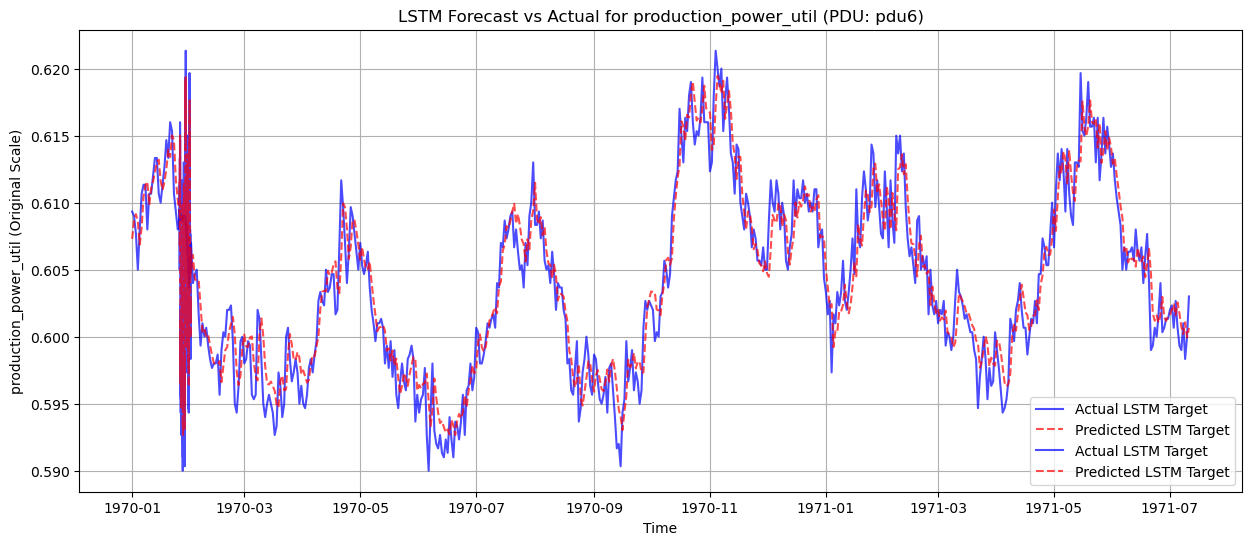

2025-05-08 22:08:37,674 - INFO - LSTM prediction plot saved to analysis_lstm_vae_output/lstm_analysis_predictions_pdu6.png
LSTM prediction plot saved to analysis_lstm_vae_output/lstm_analysis_predictions_pdu6.png
2025-05-08 22:08:37,681 - INFO - LSTM Test MSE (Original Scale): 0.000004
LSTM Test MSE (Original Scale): 0.000004


In [8]:
logging.info("\n--- LSTM Analysis ---")
print("\n--- LSTM Analysis ---")

lstm_model = LSTMModel(
    input_dim=LSTM_INPUT_DIM,
    hidden_dim=LSTM_HIDDEN_DIM,
    num_layers=LSTM_NUM_LAYERS,
    output_dim=LSTM_OUTPUT_DIM,
    dropout_prob=LSTM_DROPOUT_PROB
)
if not os.path.exists(LSTM_MODEL_PATH):
    print(f"ERROR: LSTM model file not found at {LSTM_MODEL_PATH}. Cannot perform LSTM analysis.")
else:
    try:
        lstm_model.load_state_dict(torch.load(LSTM_MODEL_PATH, map_location=DEVICE))
        lstm_model.to(DEVICE)
        lstm_model.eval()
        logging.info(f"LSTM model loaded successfully from {LSTM_MODEL_PATH}")
        print(f"LSTM model loaded successfully from {LSTM_MODEL_PATH}")

        # Make predictions
        with torch.no_grad():
            y_pred_lstm_scaled_tensor = lstm_model(X_test_lstm_tensor)
        
        y_pred_lstm_scaled = y_pred_lstm_scaled_tensor.cpu().numpy().flatten()

        # Inverse transform
        y_pred_lstm_inversed = scaler_lstm_target.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
        y_test_lstm_inversed = scaler_lstm_target.inverse_transform(y_test_lstm_np.reshape(-1, 1)).flatten() # y_test_lstm_np was already scaled

        # Plot
        plt.figure(figsize=(15, 6))
        plt.plot(y_test_lstm_inversed, label='Actual LSTM Target', color='blue', alpha=0.7)
        plt.plot(y_pred_lstm_inversed, label='Predicted LSTM Target', color='red', linestyle='--', alpha=0.7)
        plt.title(f'LSTM Forecast vs Actual for {LSTM_TARGET_COLUMN} (PDU: {TARGET_PDU})')
        plt.ylabel(LSTM_TARGET_COLUMN + " (Original Scale)")
        # Create a meaningful time axis for the test set plot
        # Assuming the original df_pdu_data index was datetime and sorted
        test_set_start_time = df_pdu_data.index[split_idx_original_data + LSTM_SEQUENCE_LENGTH]
        test_set_time_index = pd.date_range(start=test_set_start_time, periods=len(y_test_lstm_inversed), freq='15min')
        
        plt.plot(test_set_time_index, y_test_lstm_inversed, label='Actual LSTM Target', color='blue', alpha=0.7)
        plt.plot(test_set_time_index, y_pred_lstm_inversed, label='Predicted LSTM Target', color='red', linestyle='--', alpha=0.7)

        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plot_path_lstm = os.path.join(ANALYSIS_OUTPUT_DIR, f"lstm_analysis_predictions_{TARGET_PDU}.png")
        plt.savefig(plot_path_lstm)
        plt.show()
        logging.info(f"LSTM prediction plot saved to {plot_path_lstm}")
        print(f"LSTM prediction plot saved to {plot_path_lstm}")


        # Calculate MSE on original scale
        lstm_mse_original = np.mean((y_test_lstm_inversed - y_pred_lstm_inversed)**2)
        logging.info(f"LSTM Test MSE (Original Scale): {lstm_mse_original:.6f}")
        print(f"LSTM Test MSE (Original Scale): {lstm_mse_original:.6f}")

    except Exception as e:
        logging.error(f"Error during LSTM analysis: {e}", exc_info=True)
        print(f"Error during LSTM analysis: {e}")

2025-05-08 22:09:02,806 - INFO - 
--- VAE Analysis ---

--- VAE Analysis ---
2025-05-08 22:09:02,815 - INFO - VAE model loaded successfully from vae_model_output/vae_model_pdu_pdu6.pth
VAE model loaded successfully from vae_model_output/vae_model_pdu_pdu6.pth


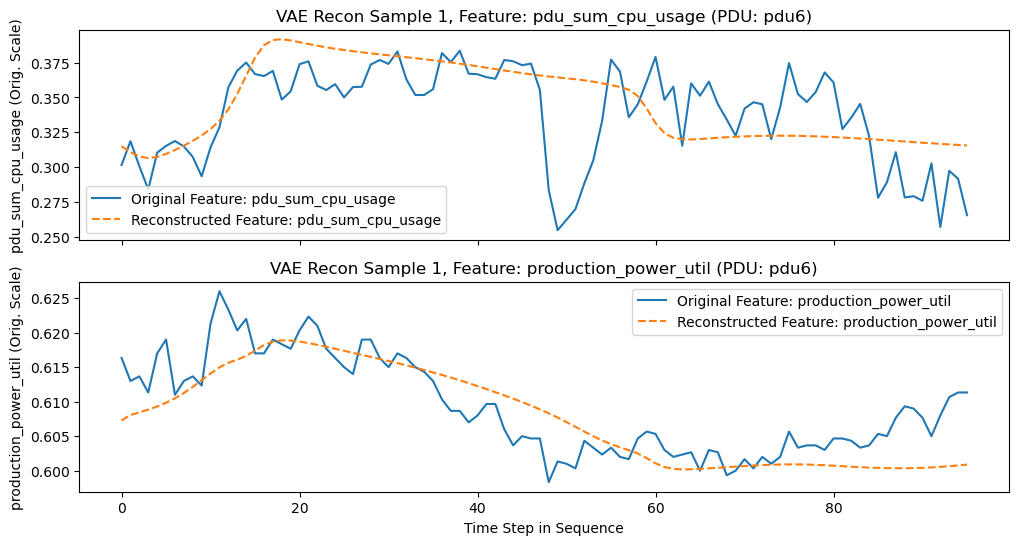

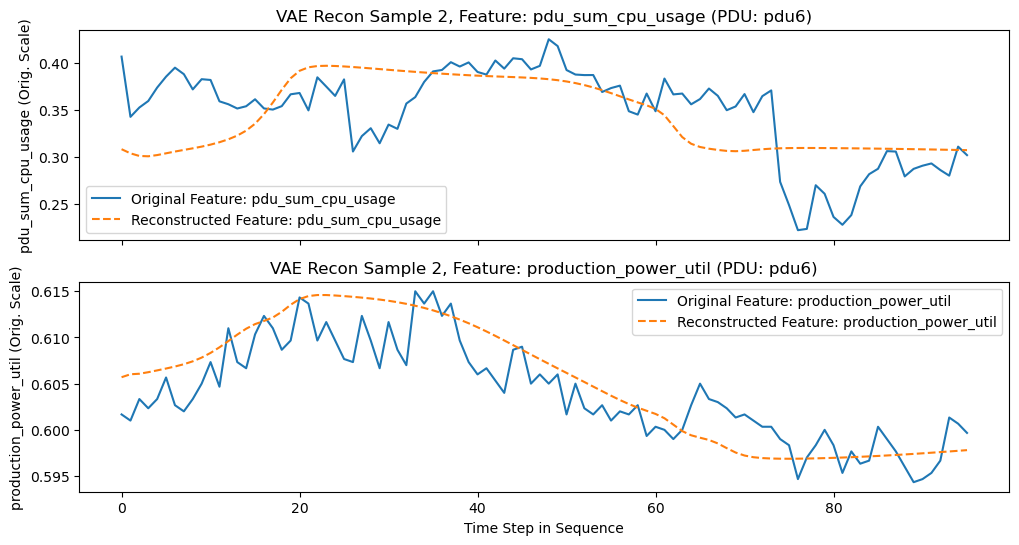

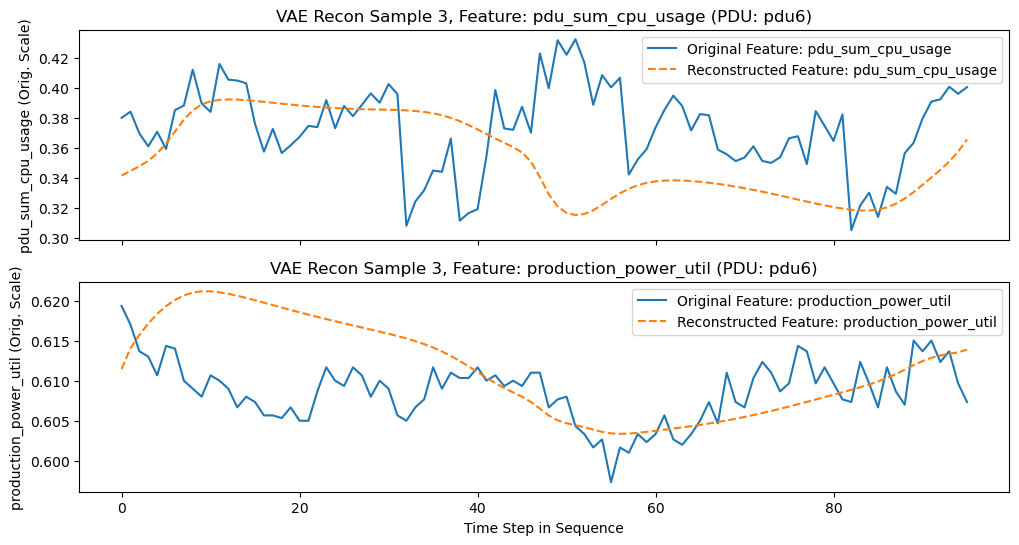

2025-05-08 22:09:04,136 - INFO - VAE reconstruction plots saved to analysis_lstm_vae_output
VAE reconstruction plots saved to analysis_lstm_vae_output
2025-05-08 22:09:04,137 - INFO - 
Generating 100 new synthetic samples with VAE...

Generating 100 new synthetic samples with VAE...
2025-05-08 22:09:04,162 - INFO - Generated 100 synthetic samples of shape (96, 2)
Generated 100 synthetic samples of shape (96, 2)
2025-05-08 22:09:04,165 - INFO - VAE generated samples saved to analysis_lstm_vae_output/vae_generated_samples_pdu_pdu6.npy
VAE generated samples saved to analysis_lstm_vae_output/vae_generated_samples_pdu_pdu6.npy


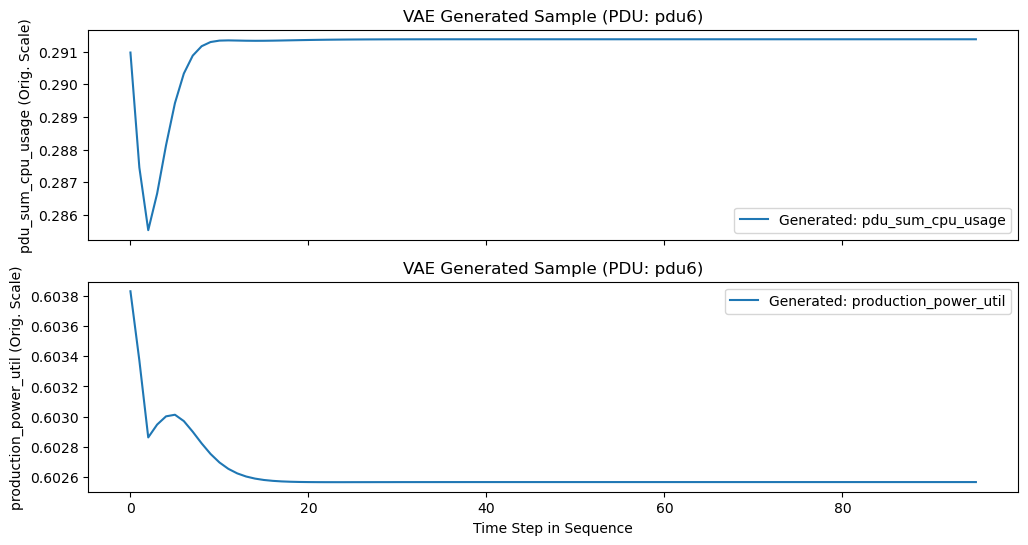

2025-05-08 22:09:04,491 - INFO - VAE generated sample plot saved to analysis_lstm_vae_output/vae_analysis_generated_sample_pdu6.png
VAE generated sample plot saved to analysis_lstm_vae_output/vae_analysis_generated_sample_pdu6.png
2025-05-08 22:09:04,492 - INFO - 
--- LSTM and VAE Analysis Notebook Finished ---

--- LSTM and VAE Analysis Notebook Finished ---


In [9]:
logging.info("\n--- VAE Analysis ---")
print("\n--- VAE Analysis ---")
vae_model_input_dim = len(VAE_FEATURE_COLUMNS) # Should be 2 based on your config
vae_model = TimeSeriesVAE(
    input_dim=vae_model_input_dim,
    sequence_length=VAE_SEQUENCE_LENGTH,
    hidden_dim=VAE_LSTM_HIDDEN_DIM,
    latent_dim=VAE_LATENT_DIM,
    num_layers=VAE_LSTM_NUM_LAYERS,
    dropout_prob=VAE_DROPOUT_PROB
)

if not os.path.exists(VAE_MODEL_PATH):
    print(f"ERROR: VAE model file not found at {VAE_MODEL_PATH}. Cannot perform VAE analysis.")
else:
    try:
        vae_model.load_state_dict(torch.load(VAE_MODEL_PATH, map_location=DEVICE))
        vae_model.to(DEVICE)
        vae_model.eval()
        logging.info(f"VAE model loaded successfully from {VAE_MODEL_PATH}")
        print(f"VAE model loaded successfully from {VAE_MODEL_PATH}")


        # 1. Reconstruct some test samples
        if X_test_vae_tensor.shape[0] > 0:
            num_reconstructions_to_plot = min(3, X_test_vae_tensor.shape[0])
            plot_indices_vae = np.random.choice(X_test_vae_tensor.shape[0], num_reconstructions_to_plot, replace=False)
            original_vae_samples_for_plot_scaled = X_test_vae_tensor[plot_indices_vae]

            with torch.no_grad():
                reconstructed_vae_samples_scaled, _, _ = vae_model(original_vae_samples_for_plot_scaled)

            # Inverse transform for plotting
            for i in range(num_reconstructions_to_plot):
                # Original sample (scaled) -> inverse transform
                original_sample_np_scaled = original_vae_samples_for_plot_scaled[i].cpu().numpy()
                original_plot = scaler_vae.inverse_transform(original_sample_np_scaled)
                
                # Reconstructed sample (scaled) -> inverse transform
                reconstructed_sample_np_scaled = reconstructed_vae_samples_scaled[i].cpu().numpy()
                reconstructed_plot = scaler_vae.inverse_transform(reconstructed_sample_np_scaled)

                fig, axs = plt.subplots(vae_model_input_dim, 1, figsize=(12, 3 * vae_model_input_dim), sharex=True)
                if vae_model_input_dim == 1: axs = [axs] # Make it iterable if only one feature

                for feature_idx in range(vae_model_input_dim):
                    axs[feature_idx].plot(original_plot[:, feature_idx], label=f'Original Feature: {VAE_FEATURE_COLUMNS[feature_idx]}')
                    axs[feature_idx].plot(reconstructed_plot[:, feature_idx], label=f'Reconstructed Feature: {VAE_FEATURE_COLUMNS[feature_idx]}', linestyle='--')
                    axs[feature_idx].set_title(f'VAE Recon Sample {i+1}, Feature: {VAE_FEATURE_COLUMNS[feature_idx]} (PDU: {TARGET_PDU})')
                    axs[feature_idx].set_ylabel(f"{VAE_FEATURE_COLUMNS[feature_idx]} (Orig. Scale)")
                    axs[feature_idx].legend()
                plt.xlabel('Time Step in Sequence')
                plot_path_vae_recon = os.path.join(ANALYSIS_OUTPUT_DIR, f"vae_analysis_reconstruction_{TARGET_PDU}_{i+1}.png")
                plt.savefig(plot_path_vae_recon)
                plt.show()
            logging.info(f"VAE reconstruction plots saved to {ANALYSIS_OUTPUT_DIR}")
            print(f"VAE reconstruction plots saved to {ANALYSIS_OUTPUT_DIR}")

        else:
            logging.info("No VAE test data to reconstruct.")
            print("No VAE test data to reconstruct.")

        # 2. Generate new synthetic samples
        NUM_SAMPLES_TO_GENERATE = 100 
        logging.info(f"\nGenerating {NUM_SAMPLES_TO_GENERATE} new synthetic samples with VAE...")
        print(f"\nGenerating {NUM_SAMPLES_TO_GENERATE} new synthetic samples with VAE...")
        vae_model.eval()
        with torch.no_grad():
           noise = torch.randn(NUM_SAMPLES_TO_GENERATE, VAE_LATENT_DIM).to(DEVICE)
           generated_samples_scaled_vae = vae_model.decode(noise)
           
           num_gen, seq_len_gen, num_feat_gen = generated_samples_scaled_vae.shape
           generated_samples_reshaped_vae = generated_samples_scaled_vae.cpu().numpy().reshape(-1, num_feat_gen)
           
           generated_samples_original_scale_vae = scaler_vae.inverse_transform(generated_samples_reshaped_vae)
           generated_samples_original_scale_vae = generated_samples_original_scale_vae.reshape(num_gen, seq_len_gen, num_feat_gen)
           
        logging.info(f"Generated {generated_samples_original_scale_vae.shape[0]} synthetic samples of shape {generated_samples_original_scale_vae.shape[1:]}")
        print(f"Generated {generated_samples_original_scale_vae.shape[0]} synthetic samples of shape {generated_samples_original_scale_vae.shape[1:]}")
        
        # Save generated samples
        generated_samples_path = os.path.join(ANALYSIS_OUTPUT_DIR, f"vae_generated_samples_pdu_{TARGET_PDU}.npy")
        np.save(generated_samples_path, generated_samples_original_scale_vae)
        logging.info(f"VAE generated samples saved to {generated_samples_path}")
        print(f"VAE generated samples saved to {generated_samples_path}")


        # Plot one generated sample (all features)
        if NUM_SAMPLES_TO_GENERATE > 0:
            fig, axs = plt.subplots(vae_model_input_dim, 1, figsize=(12, 3 * vae_model_input_dim), sharex=True)
            if vae_model_input_dim == 1: axs = [axs] 

            for feature_idx in range(vae_model_input_dim):
                axs[feature_idx].plot(generated_samples_original_scale_vae[0, :, feature_idx], label=f'Generated: {VAE_FEATURE_COLUMNS[feature_idx]}')
                axs[feature_idx].set_title(f'VAE Generated Sample (PDU: {TARGET_PDU})')
                axs[feature_idx].set_ylabel(f"{VAE_FEATURE_COLUMNS[feature_idx]} (Orig. Scale)")
                axs[feature_idx].legend()
            plt.xlabel('Time Step in Sequence')
            plot_path_vae_gen = os.path.join(ANALYSIS_OUTPUT_DIR, f"vae_analysis_generated_sample_{TARGET_PDU}.png")
            plt.savefig(plot_path_vae_gen)
            plt.show()
            logging.info(f"VAE generated sample plot saved to {plot_path_vae_gen}")
            print(f"VAE generated sample plot saved to {plot_path_vae_gen}")


    except Exception as e:
        logging.error(f"Error during VAE analysis: {e}", exc_info=True)
        print(f"Error during VAE analysis: {e}")

logging.info(f"\n--- LSTM and VAE Analysis Notebook Finished ---")
print(f"\n--- LSTM and VAE Analysis Notebook Finished ---")